# 06 Multimodal Learning - Bengali.AI

* We'll cover how to build a multimodal vision model for the [Bengali.AI](https://www.kaggle.com/c/bengaliai-cv19) competition

### The Problem:

* Given one handwritten Bengali grapheme, seperately classify three constituent elements:
  * Grapheme root
  * Vowel diacritics
  * Consonant diacritics

This notebook assumes you've already joined the competition and have downloaded the dataset to a `zip` file called "bengaliai.zip"

In [ ]:
from zipfile import ZipFile
with ZipFile('bengaliai.zip', 'r') as zip_ref:
  zip_ref.extractall('bengaliai')

# Data Prep:

We need to preprocess the data to make it easier to work with in the framework. We'll use [iafoss](https://www.kaggle.com/iafoss)' example found in [this](https://www.kaggle.com/iafoss/image-preprocessing-128x128) notebook

In [ ]:
height = 137
width = 236
size = 128

The data is stored in four `parquet` files. We can read this into `Pandas`

In [ ]:
tn = 'train_image_data_'
suf = '.parquet'

In [ ]:
train = [tn+str(i)+suf for i in range(4)]

In [ ]:
train

['train_image_data_0.parquet',
 'train_image_data_1.parquet',
 'train_image_data_2.parquet',
 'train_image_data_3.parquet']

In [ ]:
out_train = 'train.zip'

In [ ]:
import cv2
import pandas as pd

In [ ]:
# Borrowed from iafoss' notebook
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=size, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < width - 13) else width
    ymax = ymax + 10 if (ymax < height - 10) else height
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [ ]:
df = pd.read_parquet('bengaliai/' + train[0])

In [ ]:
df.head()

,image_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,32292,32293,32294,32295,32296,32297,32298,32299,32300,32301,32302,32303,32304,32305,32306,32307,32308,32309,32310,32311,32312,32313,32314,32315,32316,32317,32318,32319,32320,32321,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,253,254,253,253,253,254,253,252,253,253,253,253,252,252,253,253,252,252,253,252,252,252,253,254,253,253,252,252,252,253,...,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,252,250,250,246,249,248,250,249,251,252,253,253,253,253,253,253,253,250,249,251,252,251,251,251,251,252,253,251,250,252,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,252,253,252,252,251,250,251,253,254,251,251,252,252,253,253,252,251,251,249,251,252,252,253,252,251,251,251,250,250,252,...,253,253,252,252,252,253,253,253,253,253,252,251,251,250,250,250,251,251,251,250,250,250,251,252,253,253,253,253,254,254,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,250,251,250,249,251,251,251,250,252,251,245,245,251,252,251,252,252,250,249,250,251,250,249,250,251,252,253,252,252,252,...,253,252,252,254,253,253,254,253,252,253,254,253,252,253,254,254,254,254,254,254,254,254,253,252,253,254,253,252,253,254,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,225,231,229,229,228,221,224,226,221,221,220,217,217,218,219,222,224,214,218,227,227,227,228,224,231,235,235,233,212,183,...,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

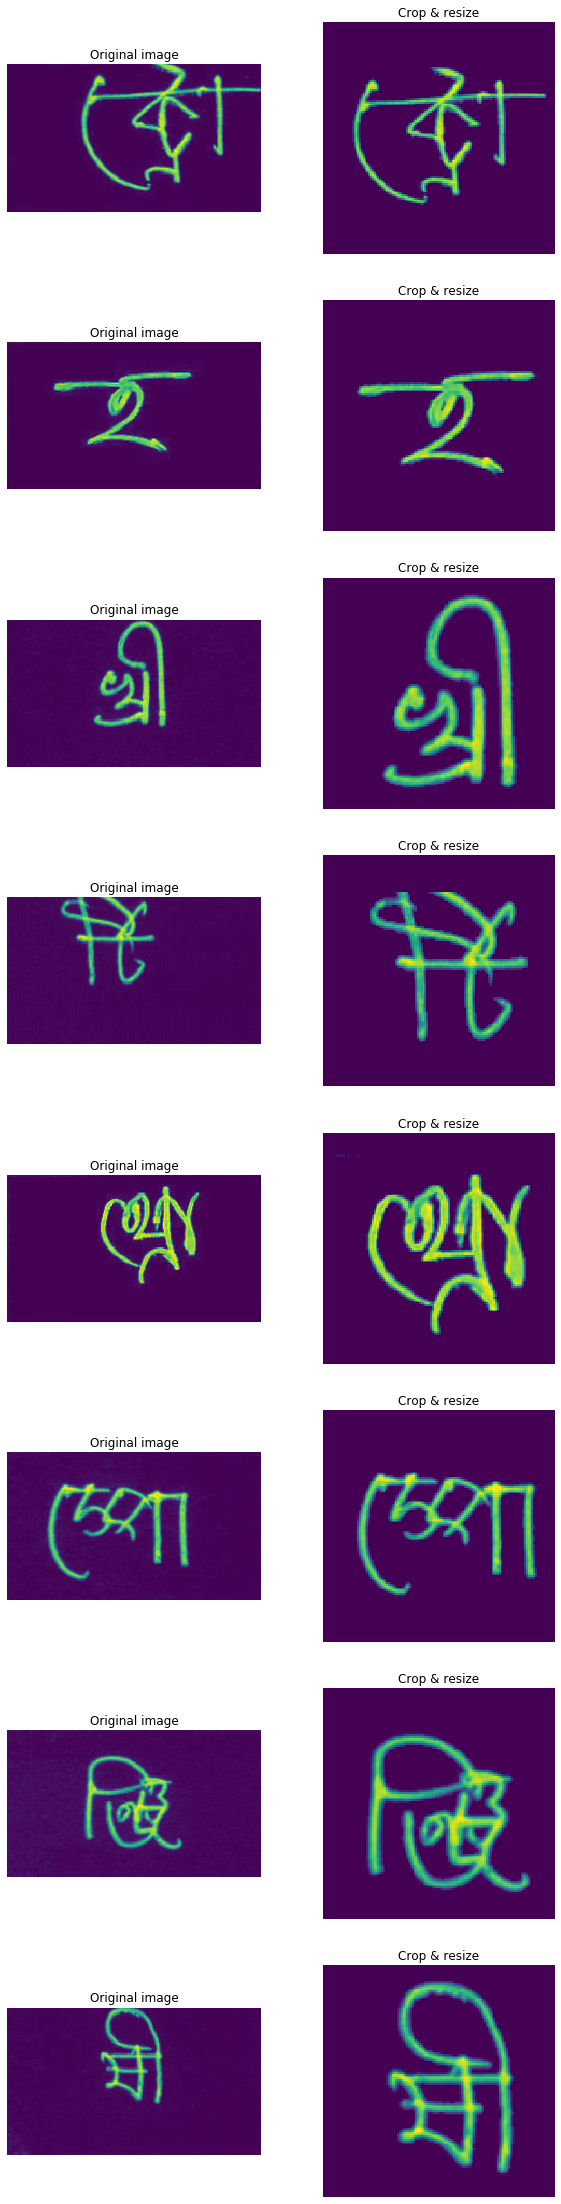

In [ ]:
n_imgs = 8
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - df.iloc[idx, 1:].values.reshape(height, width).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
plt.show()

And now we generate the dataset

In [ ]:
from tqdm import tqdm

In [ ]:
x_tot,x2_tot = [],[]
with ZipFile(out_train, 'w') as img_out:
    for fname in train:
        df = pd.read_parquet('bengaliai/'+fname)
        #the input is inverted
        data = 255 - df.iloc[:, 1:].values.reshape(-1, height, width).astype(np.uint8)
        for idx in tqdm(range(len(df))):
            name = df.iloc[idx,0]
            #normalize each image by its max val
            img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
            img = crop_resize(img)
        
            x_tot.append((img/255.0).mean())
            x2_tot.append(((img/255.0)**2).mean()) 
            img = cv2.imencode('.png',img)[1]
            img_out.writestr(name + '.png', img)

100%|██████████| 50210/50210 [02:08<00:00, 390.88it/s]


We're finally going to use our own mean and standard deviation for normalizing:

In [ ]:
mean = np.array(x_tot).mean()
std = np.sqrt(np.array(x2_tot).mean() - mean**2)
print(f'mean: {mean}, std: {std}')

mean: 0.06922848809290576, std: 0.20515700083327537


From here we can begin using `fastai`

# Building the `DataBlock`

In [ ]:
with ZipFile('train.zip', 'r') as zip_ref:
  zip_ref.extractall('images')

In [ ]:
!pip install scikit-learn fastai fastdot

In [ ]:
from fastai.vision.all import *

Out of the three/four csv files that came with it, we care about `train.csv`

In [ ]:
train = pd.read_csv('bengaliai/train.csv')
test = pd.read_csv('bengaliai/test.csv')
class_map = pd.read_csv('bengaliai/class_map.csv')

In [ ]:
train.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


First we need to know how many possible outcomes there can be. We can do this by grabbing the `.unique()` attribute from our dataframe

In [ ]:
graph_vocab = train['grapheme_root'].unique()
vowel_vocab = train['vowel_diacritic'].unique()
const_vocab = train['consonant_diacritic'].unique()

And now we generate our `DataBlocks`. We want one for our input (a B/W 2D image), and three `CategoryBlock`'s for our outcomes, each with our pre-determined vocabularies

In [ ]:
blocks = (ImageBlock(cls=PILImageBW),
          CategoryBlock(vocab=graph_vocab), 
          CategoryBlock(vocab=vowel_vocab), 
          CategoryBlock(vocab=const_vocab))

Our four getters:

In [ ]:
getters = [
           ColReader('image_id', pref='images/', suff='.png'),
           ColReader('grapheme_root'),
           ColReader('vowel_diacritic'),
           ColReader('consonant_diacritic')
]

And some transforms. We're going to use our `mean` and `std` from earlier

In [ ]:
batch_tfms = [*aug_transforms(do_flip=False, size=128), 
              Normalize.from_stats(mean=0.0692, std=0.2051)]

Finally making our `DataBlock`. We also should declare that only the first of our blocks is our input

In [ ]:
bengel = DataBlock(blocks=blocks, 
                   getters = getters,
                   splitter=RandomSplitter(),
                   batch_tfms=batch_tfms,
                   n_inp=1)

In [ ]:
bs=128

For the dataset itself, since it takes a long time to train, we'll use a 1,000 size sample

In [ ]:
dls  = bengel.dataloaders(train.sample(1000), bs=bs)

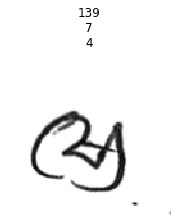

In [ ]:
dls.show_batch(max_n=1, figsize=(3,3))

# Custom Heads

For our task, we'll want three custom heads. Let's look at what their outputs need to be:

In [ ]:
n = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].nunique(); print(n)

grapheme_root          168
vowel_diacritic         11
consonant_diacritic      7
dtype: int64


In [ ]:
dls.c

(#3) [168,11,7]

For the body of our model, we'll use a standard resnet34. We need to modify the first `ConvLayer` so that it accepts a 1D image. There are a few ways to go about this. I chose this particular method:

In [ ]:
body = create_body(resnet34, pretrained=True)

In [ ]:
l = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2),
                    padding=(3,3), bias=False)
l.weight = nn.Parameter(l.weight.sum(dim=1, keepdim=True))

In [ ]:
body[0] = l

### Helper Functions

In [ ]:
from fastdot import *

In [ ]:
def _fillcolor(o:str):
  if 'Lin' in o:
    return 'lightblue'
  elif 'ReLU' in o:
    return 'gray'
  elif 'Flatten' in o:
    return 'white'
  elif 'Pooling' in o:
    return 'pink'
  elif 'Conv' in o:
    return 'white'
  else:
    return 'gold'

node_defaults['fillcolor'] = _fillcolor

In [ ]:
graph = ['2DPooling', 'Flatten', 'Lin (1024, 512)', 'ReLU', 'Lin (512, 168)']
vow = ['2DPooling', 'Flatten', 'Lin (1024, 512)', 'ReLU', 'Lin (512, 11)']
const = ['2DPooling', 'Flatten', 'Lin (1024, 512)', 'ReLU', 'Lin (512, 7)']
body1 = ['Conv2d (3, 512, 512)']
out = ['G (bs, 168)\n V (bs,   11)\n C (bs,    7)']
block1, block2, block3, block4, block5 = ['ResNet Body', 'Grapheme Head', 'Vowel Head', 'Consonant Head', 'Model Output']
conns = ((block1, block2),
        (block1, block3),
        (block1, block4),
        (block4, block5),
        (block3, block5),
        (block2, block5),
        (graph[-3], graph[4]),
        (vow[-3], vow[4]),
        (const[-3], const[4]))
visual = graph_items(seq_cluster(body1, block1),
                seq_cluster(graph, block2),
                seq_cluster(vow, block3),
                seq_cluster(const, block4),
                seq_cluster(out, block5))
visual.add_items(*object_connections(conns))

(#9) [<pydot.Edge object at 0x7fd065ec4748>,<pydot.Edge object at 0x7fd065f11a20>,<pydot.Edge object at 0x7fd065ec4be0>,<pydot.Edge object at 0x7fd065fd95c0>,<pydot.Edge object at 0x7fd065f25be0>,<pydot.Edge object at 0x7fd065f2ba58>,<pydot.Edge object at 0x7fd065eda160>,<pydot.Edge object at 0x7fd065eb3748>,<pydot.Edge object at 0x7fd065ede7b8>]

### Visualizing MultiModel Head

And now let's take a look at the head of the model we plan on making, with some assistance from the `fastdot` library (if you want to see how I do this, look at the `Helper Functions` section

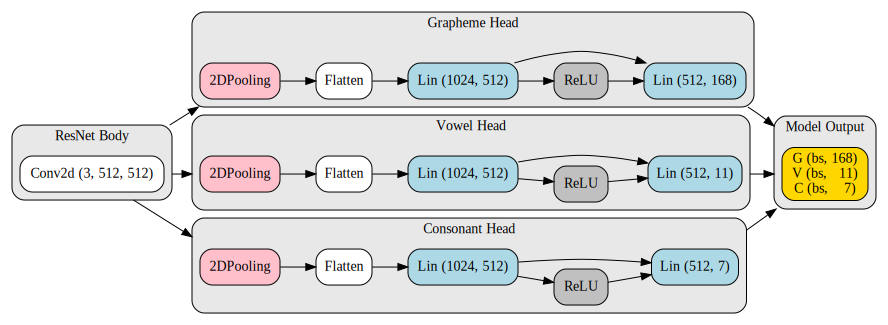

In [ ]:
visual

In [ ]:
from fastai.vision.all import *

In [ ]:
class MultiModel(Module):
  "A three-headed model given a `body` and `n` output features"
  def __init__(self, body:nn.Sequential, n:L):
    nf = num_features_model(nn.Sequential(*body.children())) * (2)
    self.body = body
    self.grapheme = create_head(nf, n[0])
    self.vowel = create_head(nf, n[1])
    self.consonant = create_head(nf, n[2])
  
  def forward(self, x):
    y = self.body(x)
    graph = self.grapheme(y)
    vowel = self.vowel(y)
    const = self.consonant(y)
    return [graph, vowel, const]

In [ ]:
net = MultiModel(body, dls.c)

# Training

We're going to want a custom loss function here. We'll base it on Miguel Pinto's notebook [here](https://www.kaggle.com/mnpinto/bengali-ai-fastai-starter-lb0-9598). 

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
class CombinationLoss(Module):
    "Cross Entropy Loss on multiple targets"
    def __init__(self, func=F.cross_entropy, weights=[2, 1, 1]):
        self.func, self.w = func, weights

    def forward(self, xs, *ys, reduction='mean'):
        for i, w, x, y in zip(range(len(xs)), self.w, xs, ys):
            if i == 0: loss = w*self.func(x, y, reduction=reduction) 
            else: loss += w*self.func(x, y, reduction=reduction) 
        return loss

In [ ]:
class RecallPartial(Metric):
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, a=0, **kwargs):
        self.func = partial(recall_score, average='macro', zero_division=0)
        self.a = a

    def reset(self): self.targs,self.preds = [],[]

    def accumulate(self, learn):
        pred = learn.pred[self.a].argmax(dim=-1)
        targ = learn.y[self.a]
        pred,targ = to_detach(pred),to_detach(targ)
        pred,targ = flatten_check(pred,targ)
        self.preds.append(pred)
        self.targs.append(targ)

    @property
    def value(self):
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        return self.func(targs, preds)

    @property
    def name(self): return train.columns[self.a+1]
    
class RecallCombine(Metric):
    def accumulate(self, learn):
        scores = [learn.metrics[i].value for i in range(3)]
        self.combine = np.average(scores, weights=[2,1,1])

    @property
    def value(self):
        return self.combine

Finally we'll declare our model:

In [ ]:
learn = Learner(dls, net, loss_func=CombinationLoss(),
                metrics=[RecallPartial(a=i) for i in range(len(dls.c))] + [RecallCombine()],
                )

And train for a few epochs!

In [ ]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,grapheme_root,vowel_diacritic,consonant_diacritic,recall_combine,time
0,15.632171,14.646649,0.000000,0.125731,0.093856,0.054897,02:20
1,15.158998,15.095473,0.001570,0.142937,0.166886,0.078240,02:21
2,14.382955,13.836717,0.011765,0.367167,0.250423,0.160280,02:21
3,13.510475,15.261553,0.045168,0.548404,0.300556,0.234824,02:22
4,12.596236,12.357647,0.045889,0.518127,0.380626,0.247633,02:20
5,11.699824,11.481838,0.052659,0.541236,0.360122,0.251669,02:21
6,10.808505,10.726472,0.092893,0.566122,0.428208,0.295029,02:20
7,10.017626,10.241068,0.098435,0.594924,0.457250,0.312261,02:20
8,9.335468,10.105422,0.080303,0.624752,0.468557,0.313478,02:20
9,8.779164,10.040724,0.085619,0.610669,0.478495,0.315101,02:20
